# Class 16:  Bayesian Networks
## This notebook prepares the discretized data matrix from the phospho-flow cytometry data from Sachs et al. (Science, 2005).

In this notebook, nine Excel spreadsheets from the supplementary data files from the Sachs et al. article are loaded and combined in a single 11-column data frame.  Each column is discretized into three classes (low, medium, high) based on the values in the column. The breakpoints for the discretization are assigned on a column-by-column basis, selected (in a single global optimization) to maximize the sum of the mutual information of all pairs of columns of discretized data. The initial breakpoints for the discretization are the column-wise quantiles (0, 1/3, 2/3, 1). The resulting discretized data matrix is saved as a tab-delimited text file "sachs_data_discretized.txt".

Read all of the 9 Excel spreadsheets in the subdiretory "shared/sachs_datafiles" into a single data frame

In [16]:
data_dir_name <- "shared/sachs_datafiles"
data_file_names <- dir(data_dir_name)

names(data_file_names) <- data_file_names
library(gdata)
suppressWarnings(data_matrix_orig <- do.call(rbind,
                     lapply(data_file_names,
                    function(data_file_name) {
                        data.frame(read.xls(paste(c(data_dir_name,
                                     "/",
                                     data_file_name), collapse="")),
                                   expt=strsplit(data_file_name,".xls")[[1]])
                    })))
rownames(data_matrix_orig) <- NULL
data_matrix <- data_matrix_orig[,1:11]

define a function for computing the mutual information of a Mx2 matrix of factors

In [5]:
## df should be a M x n data frame of factors
joint_entropy_df_cols <- function(df) {
    stopifnot(is.data.frame(df))
    stopifnot(is.factor(df[,1]))
    
    n <- ncol(df)
    M <- nrow(df)
    
    ## use "xtabs" to tabulate the number of occurrences of each combination of logical
    ## values for the n inputs; divide by M and call the resulting matrix "probmat"
    probmat <- xtabs(~., df)/M

    ## define a matrix "hmat" that is the negative of probmat element-wise-times log2 of probmat
    hmat <- -probmat*log2(probmat)
    
    ## some entries of hmat will be NaN (do you know why?).  Set them to zero
    hmat[is.nan(hmat)] <- 0
    
    ## return the sum of entries of hmat
    sum(hmat)
}

mutual_information <- function(df_twocols) {
    stopifnot(is.data.frame(df_twocols))
    stopifnot(ncol(df_twocols) == 2)
    stopifnot(is.factor(df_twocols[,1]))
    
    joint_entropy_df_cols(df_twocols[,1, drop=FALSE]) +
        joint_entropy_df_cols(df_twocols[,2, drop=FALSE]) -
        joint_entropy_df_cols(df_twocols)
}

run a couple of simple tests on your mutual information code

In [6]:
## this should give a value close to zero
dftest1 <- data.frame(factor(sample(1:3, replace=TRUE, size=100000)),factor(sample(1:3, replace=TRUE, size=100000)))
print(sprintf("independent ternary RVs:  this should give a value close to zero: %f", mutual_information(dftest1)))

## this should give a value close to log2(3) = 1.584963
dftest2 <- data.frame(dftest1[,1],dftest1[,1])
print(sprintf("identical (as in perfectly correlated) ternary RVs:  this should give a value close to 1.584963: %f", mutual_information(dftest2)))

[1] "independent ternary RVs:  this should give a value close to zero: 0.000052"
[1] "identical (as in perfectly correlated) ternary RVs:  this should give a value close to 1.584963: 1.584962"


obtain an initial ternary discretization of the columns of the matrix, using 1/3 and 2/3 quantiles as breakpoints

In [7]:
discret_breaks_initial <- apply(data_matrix, 2, function(data_matrix_col) {
    quantile(data_matrix_col, c(0, 1/3, 2/3, 1))
})

optimize the ternary discretization breakpoints for each of the columns so that the summed (total) mutaul information for all pairs of columns is maximal

In [9]:
compute_sum_mut_inf_given_discret_breaks <- function(data_matrix, discret_breaks) {
    ## discretize the data matrix
    discret_data_frame <- data.frame(lapply(1:ncol(data_matrix), function(col_num) {
        cut(data_matrix[,col_num],
            breaks=discret_breaks[,col_num])
    }))

    # compute the mutual information for all possible pairs of variables, and sum
    sum(apply(combn(1:ncol(data_matrix), 2), 2, function(pair_col_nums) {
        mutual_information(discret_data_frame[, pair_col_nums])
    }))
}

opt_res <- optim(as.vector(discret_breaks_initial[2:3, ]),
                 function(discret_breaks_internal_vec) {
                     discret_breaks_matrix <- discret_breaks_initial
                     discret_breaks_matrix[2:3, ] <- discret_breaks_internal_vec
                     
                     compute_sum_mut_inf_given_discret_breaks(data_matrix, discret_breaks_matrix)
                 },
                 lower=discret_breaks_initial[1,],
                 upper=discret_breaks_initial[4,],
                 control=list(fnscale=-1, trace=1),
                 method="L-BFGS-B")

discret_breaks_final <- discret_breaks_initial
discret_breaks_final[2:3, ] <- opt_res$par

final  value -6.834433 
converged


make a discretized data matrix based on the optimal discretization breakpoints selected by `optim`

In [10]:
data_matrix_discrete <- data.frame(lapply(1:ncol(data_matrix), function(col_num) {
    myfac <- cut(data_matrix[,col_num],
        breaks=discret_breaks_final[,col_num])
    levels(myfac) <- c("low", "medium", "high")
    myfac
}))
names(data_matrix_discrete) <- colnames(data_matrix)

as a check on the discretization, for each column in the original data matrix, plot the original expression levels vs. the discretized categories

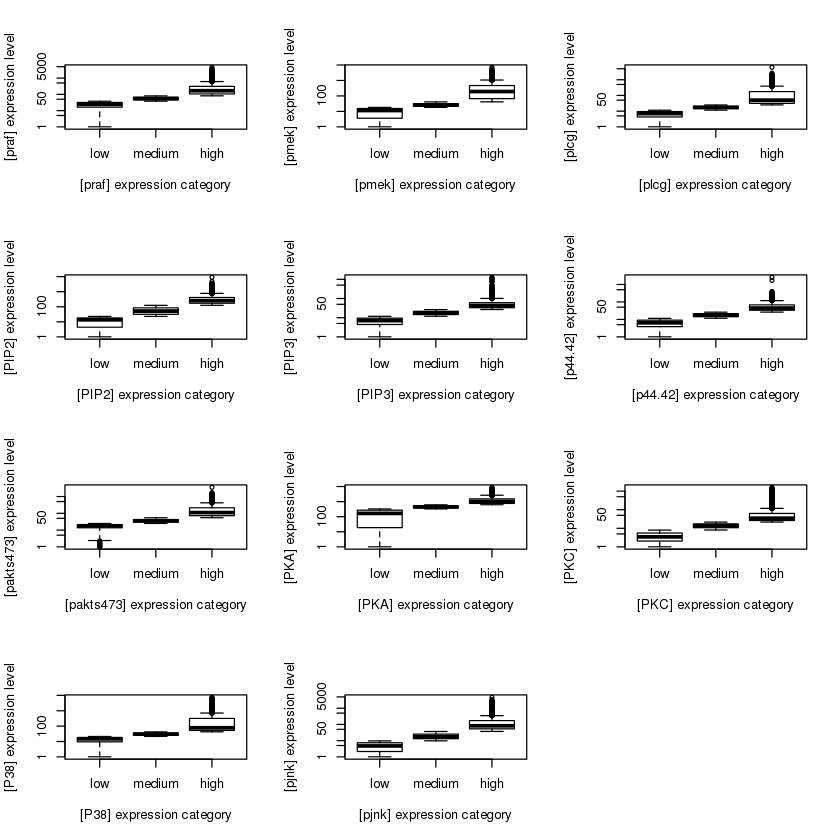

In [13]:
par(mfrow=c(4,3))
invisible(sapply(1:11,
       function(col_num) {
           protein_name <- names(data_matrix_discrete)[col_num]
           plot(data_matrix_discrete[,col_num],
                data_matrix[,col_num], log="y", xlab=sprintf("[%s] expression category", protein_name),
                ylab=sprintf("[%s] expression level", protein_name))}))


add a column indicating the experiment name for each row to the discretized data matrix; then save the matrix

In [15]:
data_matrix_final <- data.frame(data_matrix_discrete, expt=data_matrix_orig[,12])

write.table(data_matrix_final,
            file="sachs_data_discretized.txt",
            sep="\t",
            row.names=FALSE,
            col.names=TRUE,
            quote=FALSE)